In [2]:
import scanpy as sc

# Read the h5ad file created from Seurat
protein_data = sc.read_h5ad("data/processed/LUNG-CITE_ADT.h5ad")
rna_data = sc.read_h5ad("data/processed/LUNG-CITE_RNA.h5ad")

print(protein_data)
print(rna_data)

AnnData object with n_obs × n_vars = 10470 × 52
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
    var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_apca'
    varm: 'APCA'
AnnData object with n_obs × n_vars = 10470 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca'
    varm: 'PCs'


In [3]:
protein_data.X

array([[-0.10669741,  0.23357401, -0.37614541, ...,  0.04172973,
         0.71285179,  1.78101965],
       [-0.08164731,  0.68190831,  0.10021684, ...,  2.8419941 ,
         0.13671035, -0.23398192],
       [ 0.13347974, -0.1354818 , -0.07717761, ..., -0.80119114,
        -0.03014778, -0.7496729 ],
       ...,
       [-0.23117279,  0.46475297,  0.39534765, ...,  0.1589251 ,
        -0.9880913 ,  0.51025562],
       [-0.31135894, -1.42916725, -0.38957779, ...,  0.02726044,
         0.22199462,  1.45901696],
       [-0.47928924,  0.52412548, -1.09561088, ...,  0.86011833,
        -0.9880913 ,  0.59409302]])

# UMAP visualization

c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


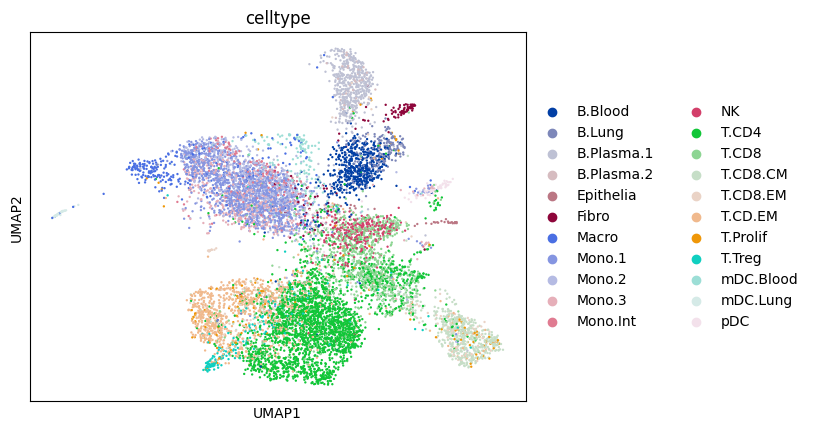

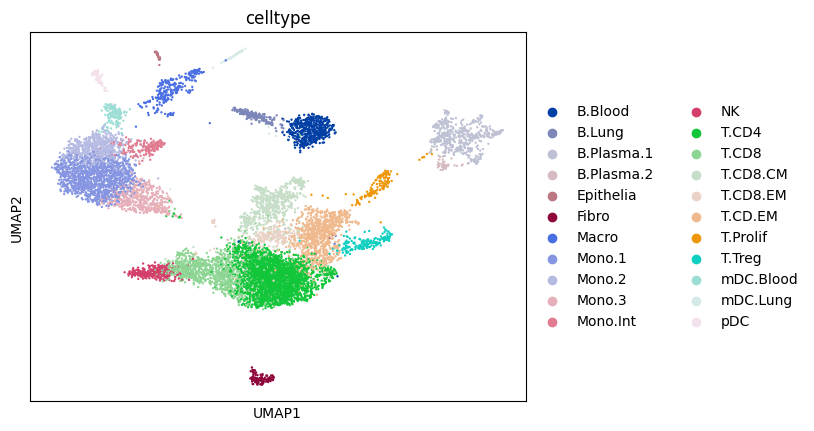

In [4]:
def UMAP_plot(adata, use_rep='X_pca'):
    # Compute the neighborhood graph using the PCA representation
    sc.pp.neighbors(adata, use_rep=use_rep)

    # Compute UMAP
    sc.tl.umap(adata)

    # Plot UMAP colored by a metadata column (e.g., celltype)
    sc.pl.umap(adata, color='celltype')

UMAP_plot(protein_data, use_rep='X_apca')
UMAP_plot(rna_data)

# Cos-similarity of cells according to ADT

In [5]:
import numpy as np

# Calculate dot product similarity matrix
dot_similarity = protein_data.X @ protein_data.X.T

# Compute the L2 norms for each row (vector)
norms = np.linalg.norm(protein_data.X, axis=1)

# Compute the outer product of the norms to form a denominator matrix
denom = np.outer(norms, norms)

# Calculate cosine similarity matrix by element-wise division
cosine_similarity = dot_similarity / denom

print(cosine_similarity.shape)

(10470, 10470)


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


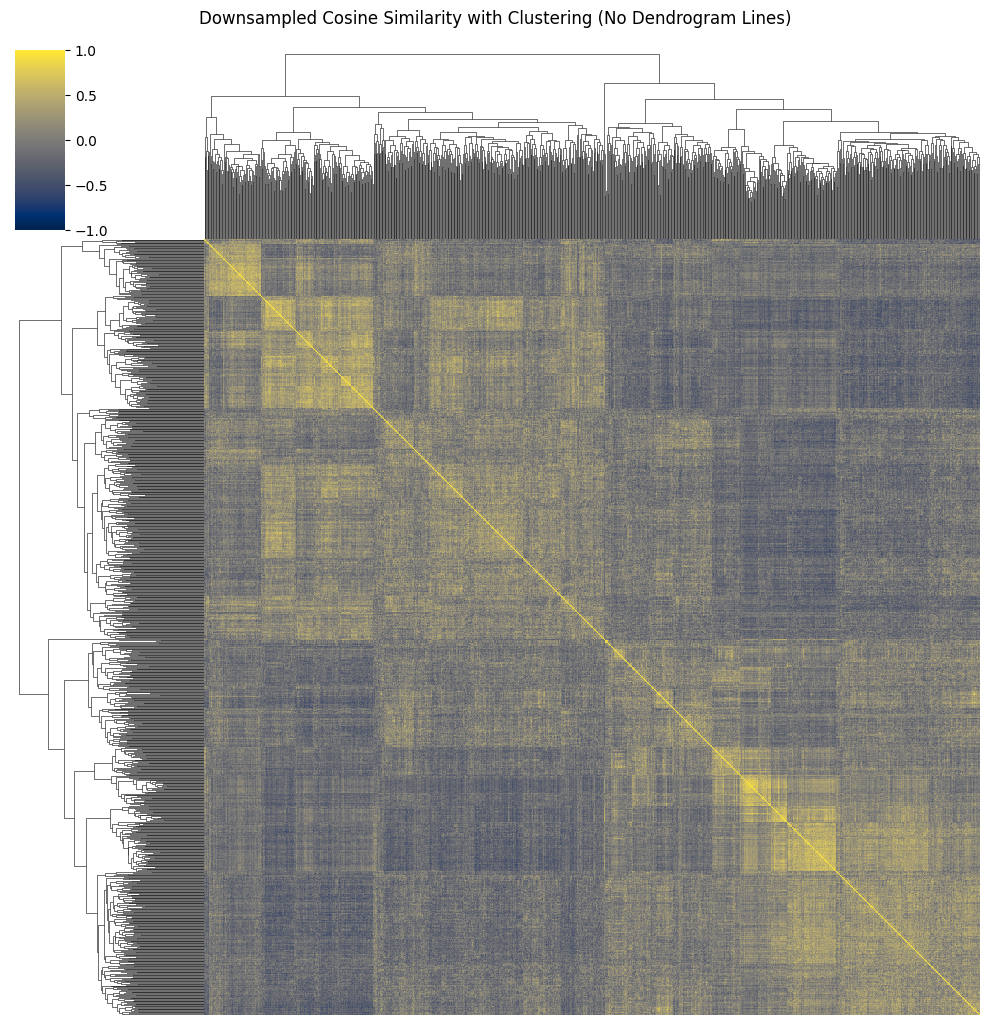

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'cosine_similarity' is your (10000x10000) cosine similarity matrix.
# Downsample the data for visualization (e.g., take every 10th row and column)
downsample_factor = 10
data_downsampled = cosine_similarity[::downsample_factor, ::downsample_factor]  # 100x100

# Convert to DataFrame for easier handling (optional)
df_downsampled = pd.DataFrame(data_downsampled)

# Create the clustermap (this will perform clustering and reorder the data)
cluster_grid = sns.clustermap(
    df_downsampled.values,
    cmap='cividis',
    figsize=(10, 10),
    vmin=-1,
    vmax=1,
    xticklabels=False,
    yticklabels=False
)

# Optionally, adjust the title and show the plot
cluster_grid.fig.suptitle('Downsampled Cosine Similarity with Clustering (No Dendrogram Lines)', y=1.02)
plt.show()

In [8]:
print(f'mean: {np.mean(cosine_similarity)}, median: {np.median(cosine_similarity)}, std: {np.std(cosine_similarity)}')

mean: 0.0004824852421151624, median: -0.01622844012543304, std: 0.19720999401631473


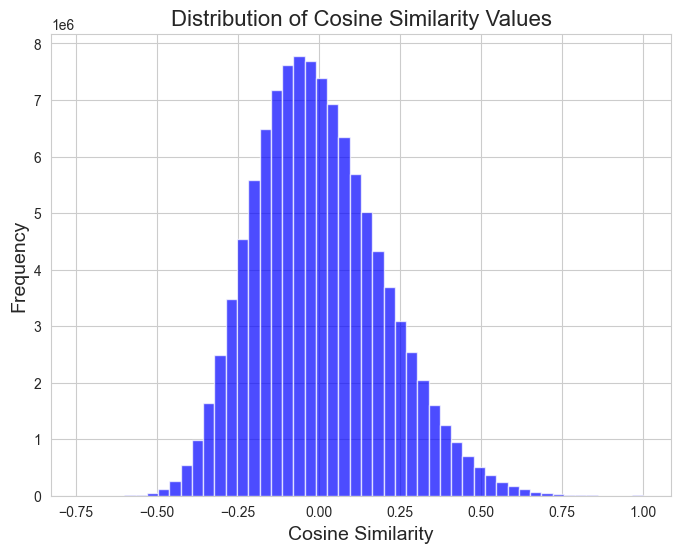

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the distribution of cosine similarity values
plt.figure(figsize=(8, 6))
plt.hist(cosine_similarity.flatten(), bins=50, color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Cosine Similarity Values', fontsize=16)
plt.grid(True)
plt.show()

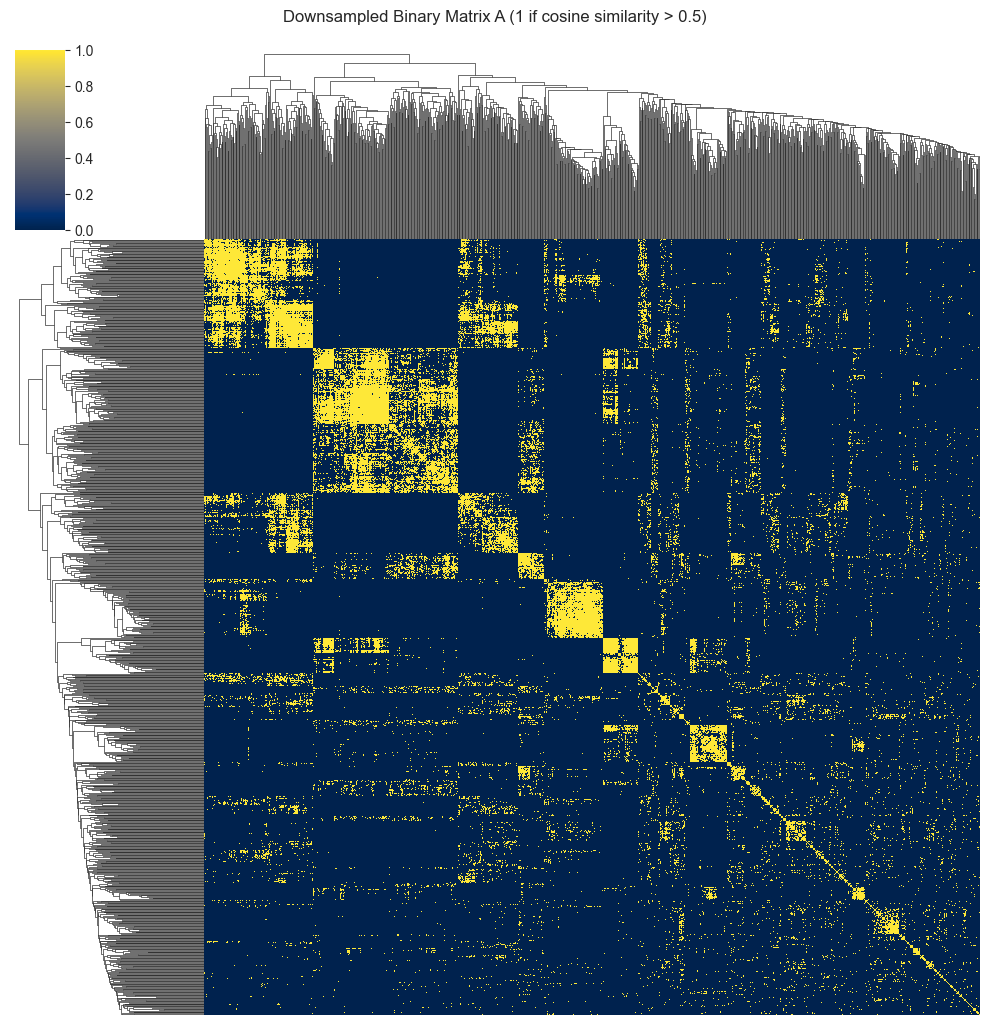

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume cosine_similarity is your computed (10000x10000) cosine similarity matrix
# Create binary matrix A: set A[i, j] = 1 if cosine_similarity[i, j] > 0.5, else 0
A = (cosine_similarity > 0.3).astype(int)

# Downsample the matrix for visualization (e.g., take every 10th row and column)
downsample_factor = 10
A_downsampled = A[::downsample_factor, ::downsample_factor]  # This gives a 100 x 100 matrix

# Convert to DataFrame (optional but can help with handling the data)
df_A = pd.DataFrame(A_downsampled)

# Create the clustermap, which performs the clustering
cluster_grid = sns.clustermap(
    df_A.values,
    cmap='cividis',    # You can choose a colormap suited for binary data
    figsize=(10, 10),
    vmin=0,
    vmax=1,
    xticklabels=False,
    yticklabels=False
)


# Adjust the title (optional)
cluster_grid.fig.suptitle('Downsampled Binary Matrix A (1 if cosine similarity > 0.5)', y=1.02)
plt.show()

# MOJITOO

In [ ]:
import mojitoo
import mudatasets as mds
import scanpy as sc

mds.list_datasets()

adt = protein_data
rna = rna_data


protein_data.obsm["pca"] = rna.obsm["X_pca"]
protein_data.obsm["apca"] = adt.obsm["X_apca"]


mojitoo.mojitoo(protein_data, reduction_list=["pca", "apca"],  dims_list=(range(50), range(1,50)),reduction_name='mojitoo', overwrite=True)


ModuleNotFoundError: No module named 'mojitoo'

In [ ]:
import os
os.environ["R_HOME"] = "C:/Program Files/R/R-4.4.2"  # Adjust path to your R install C:\Program Files\R\R-4.4.2
os.environ["R_USER"] = os.path.expanduser("~")

import anndata2ri
anndata2ri.activate()
import scanpy as sc

# Set PCA and APCA representations
protein_data.obsm["pca"] = rna_data.obsm["X_pca"]
protein_data.obsm["apca"] = protein_data.obsm["X_apca"]

import anndata2ri
r_protein_data = anndata2ri.py2rpy(protein_data)


import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Import the MOJITOO package (assumes it is installed in your R library)
mojitoo = importr("MOJITOO")

ro.globalenv["protein_data_r"] = r_protein_data

ro.r('''
    library(MOJITOO)
    result <- mojitoo(
      protein_data_r,
      reduction_list = list("pca", "apca"),
      dims_list = list(0:49, 1:49),  # Note: R indexing typically starts at 0 or 1 depending on implementation. Adjust as needed.
      reduction_name = "mojitoo",
      overwrite = TRUE
    )
''')


: 

In [32]:
protein_data

AnnData object with n_obs × n_vars = 10470 × 52
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT', 'louvain'
    var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_apca', 'pca', 'apca', 'mojitoo', 'X_umap'
    varm: 'APCA'
    obsp: 'distances', 'connectivities'

conda install -c conda-forge openblas

conda install -c conda-forge python-igraph

conda install -c conda-forge louvain

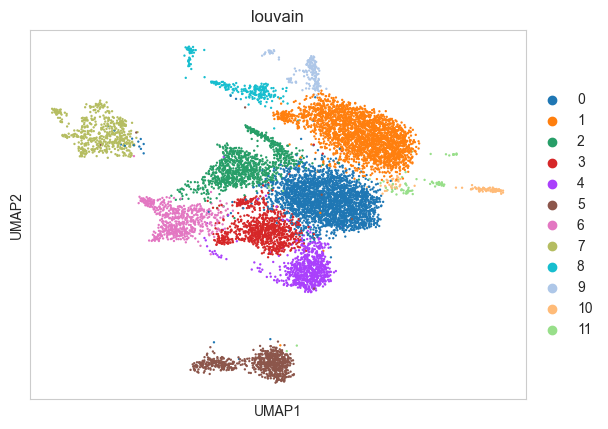

In [31]:
sc.pp.neighbors(protein_data, use_rep='mojitoo')
sc.tl.louvain(protein_data, resolution=0.5)
sc.tl.umap(protein_data)
sc.pl.embedding(protein_data, color='louvain', basis='umap')